In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import pickle
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
BATCH_SIZE = 512  # Number of examples used in each iteration
EPOCHS = 5  # Number of passes through entire dataset
EMBEDDING = 40 # Dimension of word embedding vector
RANDOM_STATE = 42

## Prepairing  and tokenize data

In [5]:
df=pd.read_csv('dataset.csv')

In [6]:
df.head()

,Sentence,Word,Label
0,1,The,0
1,1,Rocky,1
2,1,Mountains,0
3,1,is,0
4,1,an,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446 entries, 0 to 4445
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  4446 non-null   int64 
 1   Word      4446 non-null   object
 2   Label     4446 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 104.3+ KB


In [8]:
df["Word"].nunique()

1299

In [9]:
print('Number of sentences are '+str(df['Sentence'].nunique()))
print('Number of Vocabs are '+str(df['Word'].nunique()))

Number of sentences are 205
Number of Vocabs are 1299


In [10]:
sentences = df.groupby("Sentence")["Word"].apply(list).values
labels = df.groupby("Sentence")["Label"].apply(list).values

In [11]:
MAX_LEN = len(max(sentences, key=len))
MAX_LEN

51

In [12]:
train_data, val_data, train_labels, val_labels = train_test_split(sentences, labels, test_size=0.2, random_state=RANDOM_STATE)

In [13]:
def pad_labels(y):
    tag = list()
    for i in y:
        tag.append(np.array(i + [0] * (MAX_LEN-len(i))))
        
    return np.array(tag)

In [14]:
y_train = pad_labels(train_labels)
y_val = pad_labels(val_labels)

In [15]:
vocab_size = df["Word"].nunique()
oov = '<OOV>'
padding = 'post'

In [16]:
# Fit Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov)
tokenizer.fit_on_texts(train_data)
tokenizer.fit_on_texts(val_data)

In [17]:
# Converting words into token sequences
sequences_train = tokenizer.texts_to_sequences(train_data)
sequences_val = tokenizer.texts_to_sequences(val_data)

# Padded sequences to make them same length
X_train = pad_sequences(sequences_train, padding=padding, maxlen=MAX_LEN)
X_val = pad_sequences(sequences_val, padding=padding, maxlen=MAX_LEN)

## Creating model

In [18]:
embedding_dim = 300
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(MAX_LEN, embedding_dim, input_length=MAX_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 51, 300)           15300     
                                                                 
 bidirectional (Bidirectiona  (None, 51, 256)          439296    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 51, 256)          394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 51, 128)           32896     
                                                                 
 dropout (Dropout)           (None, 51, 128)           0         
                                                                 
 dense_1 (Dense)             (None, 51, 1)             1

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='ner.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

In [22]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((164, 51), (164, 51), (41, 51), (41, 51))

In [23]:
num_epochs = 70
batch_size = 32
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, 
                    validation_data=(X_val, y_val), callbacks=[save_model], verbose=1)

Epoch 1/70
6/6 [==============================] - ETA: 0s - loss: 0.5049 - accuracy: 0.8928
Epoch 1: val_loss improved from inf to 0.05223, saving model to ner.h5
6/6 [==============================] - 9s 349ms/step - loss: 0.5049 - accuracy: 0.8928 - val_loss: 0.0522 - val_accuracy: 0.9904
Epoch 2/70
6/6 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.9927
Epoch 2: val_loss did not improve from 0.05223
6/6 [==============================] - 1s 173ms/step - loss: 0.0597 - accuracy: 0.9927 - val_loss: 0.1022 - val_accuracy: 0.9904
Epoch 3/70
6/6 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9927
Epoch 3: val_loss did not improve from 0.05223
6/6 [==============================] - 1s 170ms/step - loss: 0.0668 - accuracy: 0.9927 - val_loss: 0.0732 - val_accuracy: 0.9904
Epoch 4/70
6/6 [==============================] - ETA: 0s - loss: 0.0457 - accuracy: 0.9927
Epoch 4: val_loss improved from 0.05223 to 0.05031, saving model to ner.h5
6/6 [

Epoch 31/70
6/6 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9953
Epoch 31: val_loss did not improve from 0.04306
6/6 [==============================] - 0s 59ms/step - loss: 0.0182 - accuracy: 0.9953 - val_loss: 0.0435 - val_accuracy: 0.9909
Epoch 32/70
6/6 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9950
Epoch 32: val_loss did not improve from 0.04306
6/6 [==============================] - 1s 81ms/step - loss: 0.0181 - accuracy: 0.9950 - val_loss: 0.0486 - val_accuracy: 0.9914
Epoch 33/70
6/6 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.9956
Epoch 33: val_loss did not improve from 0.04306
6/6 [==============================] - 0s 79ms/step - loss: 0.0171 - accuracy: 0.9956 - val_loss: 0.0542 - val_accuracy: 0.9909
Epoch 34/70
5/6 [========================>.....] - ETA: 0s - loss: 0.0175 - accuracy: 0.9952
Epoch 34: val_loss did not improve from 0.04306
6/6 [==============================] - 0s 36ms/step 

5/6 [========================>.....] - ETA: 0s - loss: 0.0052 - accuracy: 0.9983
Epoch 61: val_loss did not improve from 0.03924
6/6 [==============================] - 0s 39ms/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.0614 - val_accuracy: 0.9928
Epoch 62/70
5/6 [========================>.....] - ETA: 0s - loss: 0.0033 - accuracy: 0.9994
Epoch 62: val_loss did not improve from 0.03924
6/6 [==============================] - 0s 36ms/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 0.0670 - val_accuracy: 0.9928
Epoch 63/70
5/6 [========================>.....] - ETA: 0s - loss: 0.0041 - accuracy: 0.9989
Epoch 63: val_loss did not improve from 0.03924
6/6 [==============================] - 0s 42ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.0679 - val_accuracy: 0.9928
Epoch 64/70
6/6 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9983
Epoch 64: val_loss did not improve from 0.03924
6/6 [==============================] - 0s 56ms/step - loss: 0.00

## Evaluating

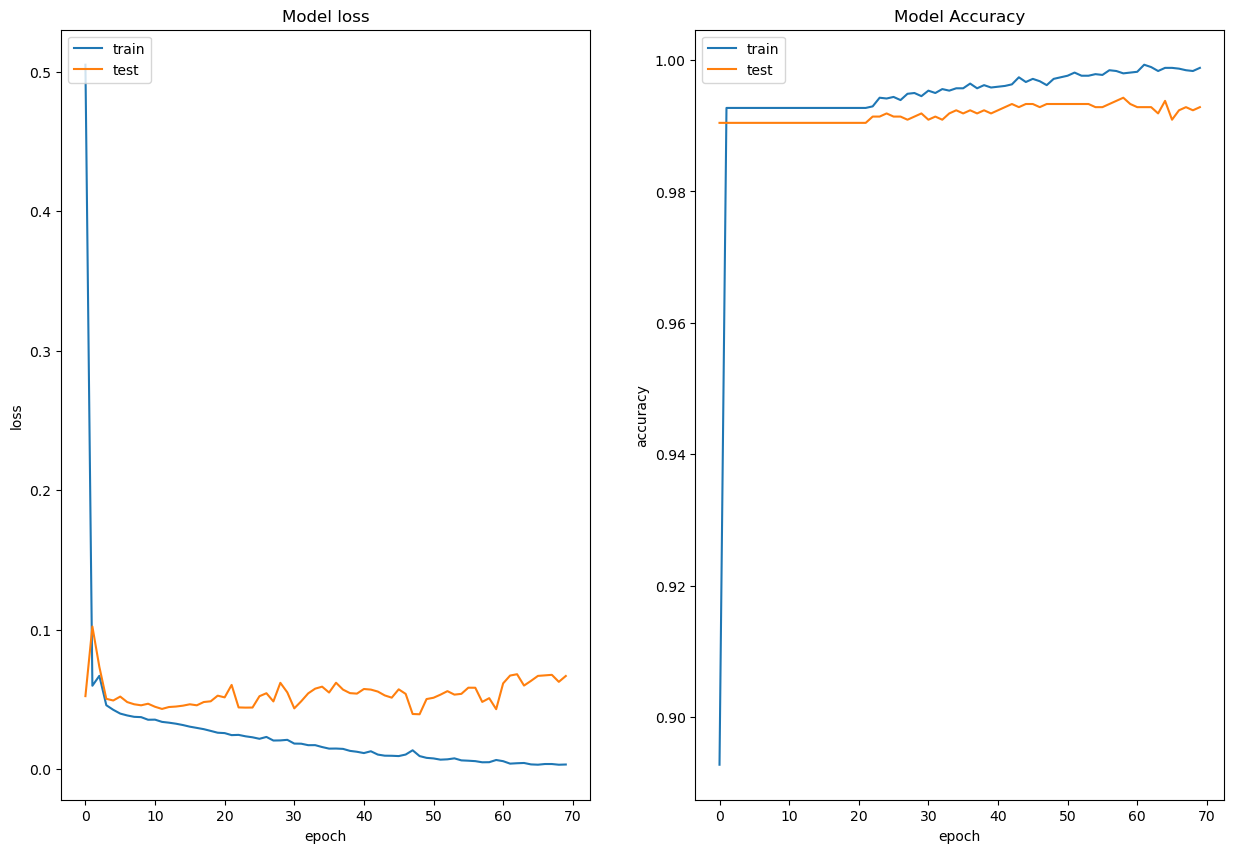

In [24]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# plt.show()

In [25]:
X_val[1].shape

(51,)

In [99]:
sentence = 'The Rocky Mountains is an extensive mountain range located in western North America.'
sentence = 'With a height of 4,810 meters, Mont Blanc is the Alps mesmerizing peak.'
sentence = 'Mountains are generally less preferable for human habitation than lowlands, because of harsh weather and little level ground suitable for agriculture. While 7% of the land area of Earth is above 2,500 metres (8,200 ft),[10]: 14  only 140 million people live above that altitude[37] and only 20-30 million people above 3,000 metres (9,800 ft) elevation.[38] About half of mountain dwellers live in the Andes, Central Asia, and Africa.'
sentence = 'Heights of mountains are typically measured above sea level. Using this metric, Mount Everest is the highest mountain on Earth, at 8,848 metres (29,029 ft).'
sentence = 'There is no precise definition of surrounding base, but Denali, Mount Kilimanjaro and Nanga Parbat are possible candidates for the tallest mountain on land by this measure.'
sentence = 'The summit of Chimborazo, Ecuador''s tallest mountain, is usually considered to be the farthest point from the Earth''s centre, although the southern summit of Peru''s tallest mountain, Huascarán, is another contender.'
sentence = 'Mount Kilimanjaro is the largest non-shield volcano in terms of both base area (245 sq mi or 635 km2) and volume (1,150 cu mi or 4,793 km3).'
sentence = 'The first recorded ascent of Mont Blanc was made in 1786 by two Chamonix mountain guides, Jacques Balmat and Michel-Gabriel Paccard.'

words = list([nltk.word_tokenize(sentence)])
sequences_text = tokenizer.texts_to_sequences(words)
padded_text = pad_sequences(sequences_text, padding=padding, maxlen=MAX_LEN, truncating='post')

In [100]:
np.squeeze(words)

array(['The', 'first', 'recorded', 'ascent', 'of', 'Mont', 'Blanc', 'was',
       'made', 'in', '1786', 'by', 'two', 'Chamonix', 'mountain',
       'guides', ',', 'Jacques', 'Balmat', 'and', 'Michel-Gabriel',
       'Paccard', '.'], dtype='<U14')

In [101]:
pred = model.predict(padded_text)

1/1 [==============================] - 0s 39ms/step


In [102]:
# res = np.rint(np.squeeze(pred, axis=None)).astype(np.uint8) 

In [103]:
res = np.squeeze(pred)

In [104]:
res

array([3.78228608e-04, 6.38981641e-04, 7.23087811e-04, 1.03415386e-03,
       5.24783973e-03, 9.15854990e-01, 9.61938739e-01, 4.08600550e-04,
       1.00646510e-04, 4.16796411e-06, 6.60368278e-06, 9.02314753e-07,
       6.05462083e-06, 1.25603365e-05, 8.34332212e-08, 2.64141136e-07,
       7.01624714e-08, 1.88397479e-07, 1.00479201e-06, 9.00345682e-08,
       4.23430834e-07, 3.75179047e-06, 2.65228351e-07, 1.14476384e-08,
       1.32504907e-09, 2.26874727e-10, 5.80382097e-11, 2.17847181e-11,
       1.12449338e-11, 7.34822446e-12, 5.63860547e-12, 4.80308024e-12,
       4.37439711e-12, 4.15985996e-12, 4.07153434e-12, 4.06798683e-12,
       4.13165465e-12, 4.25729807e-12, 4.44187742e-12, 4.67163547e-12,
       4.90906361e-12, 5.09185966e-12, 5.15370906e-12, 5.05799092e-12,
       4.81796200e-12, 4.49537629e-12, 4.19947280e-12, 4.16228033e-12,
       5.36805322e-12, 2.00190940e-11, 1.18173282e-09], dtype=float32)

In [111]:
result = np.argwhere(res>0.5)

In [113]:
padded_text

array([[  2, 225, 772, 360,   5, 270, 190,  37, 185,  10, 773,  38, 283,
        774,  12, 775,   3, 776, 777,   6, 778, 779,   4,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
      dtype=int32)

In [120]:
text = np.squeeze(words)

In [121]:
if result.shape[0] > 0:
        print("Found mountains:")
        for idx in result:
            print(text[idx[0]])

Found mountains:
Mont
Blanc


In [30]:
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

In [31]:
# model.save('ner_model.keras')